# LangChain Agent with Tool Calling (Groq + OpenAI OSS 20B)

This notebook demonstrates how to build a minimal LangChain agent using the `openai/gpt-oss-20b` model served via Groq, how tool calling works, and how to inspect the agent's behavior.

The goal is to understand:
- How an agent differs from a plain LLM.
- How the model decides to call a tool.
- What the runtime control flow looks like.


## Setup

We load environment variables, initialize the model, define a tool, and create the agent.


In [35]:
import langchain
langchain.__version__

'1.2.0'

In [49]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.agents import create_agent

load_dotenv()

True

## Define a Tool

This function represents an external capability the agent can call.  
The name, signature, and docstring tell the model when and how to use it.


In [ ]:
def get_weather(city: str) -> str:
    """Get the weather for a city."""
    return f"The weather in {city} is sunny."



## Initialize the Model

We use the open-weight OpenAI 20B model served through Groq.


In [66]:
# Initialize Groq LLM
llm = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY"),
    model= "openai/gpt-oss-20b",
    temperature=0
)

## Create the Agent

The agent wraps the model and gives it permission to call tools.

### Agent without Tools — Linear Execution

This diagram shows a linear execution graph:

start → model → end

The user input flows directly into the language model, and the model produces an answer without any intermediate actions.

In this setup:
- The model can only use its internal training and reasoning.
- No external systems can be queried.
- No functions can be executed.
- The output is always generated directly by the model.

This represents the simplest possible agent loop and behaves like a plain LLM wrapped in an agent interface.


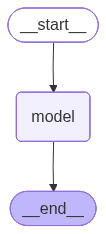

In [61]:
# Create agent
agent = create_agent(
    model=llm,
    tools=[],
    system_prompt="You are a helpful assistant.",
)
agent

### Agent with Tools — Conditional Execution

This diagram shows a conditional execution graph:

start → model → tools → model → end

Here, the model does not always go directly to the end. Instead, it can decide to route execution through a tool before producing a final answer.

In this setup:
- The model first analyzes the user request.
- If it determines external information or an action is required, it emits a tool call.
- The tool is executed by the runtime.
- The tool’s output is fed back into the model.
- The model then generates the final response.

This structure allows the agent to go beyond static knowledge and interact with external systems when necessary.


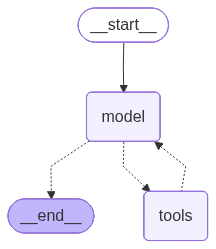

In [ ]:
  
# Create agent
agent = create_agent(
    model=llm,
    tools=[get_weather],
    system_prompt="You are a helpful assistant.",
)
agent

## Run the Agent

We ask a question that requires external information.

In [ ]:
### run the agent
response=agent.invoke({"messages":[{"role":"user","content":"What is the weather like in New York?"}]})

{'messages': [HumanMessage(content='What is the weather like in New York?', additional_kwargs={}, response_metadata={}, id='0cf15ffc-0a41-472a-a780-6a2787a13588'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call get_weather function with city "New York".', 'tool_calls': [{'id': 'fc_5f08db42-21a3-425c-b6bd-b29391b9775c', 'function': {'arguments': '{"city":"New York"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 138, 'total_tokens': 176, 'completion_time': 0.041479458, 'completion_tokens_details': {'reasoning_tokens': 14}, 'prompt_time': 0.007662641, 'prompt_tokens_details': None, 'queue_time': 0.003024841, 'total_time': 0.049142099}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_334cc21c60', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b71aa-7ed5-76b1-89fd-5b4c7efc9584-0', tool_calls=[{'

## Extract the Final Answer

The full response contains internal metadata.  
The last message contains the final user-facing answer.

In [64]:
response["messages"][-1].content

'The weather in New\u202fYork is sunny.'

## Shorthand Invocation

The agent also accepts a simpler input format.


In [65]:
agent.invoke({"messages":"What is the weather in New Yourk"})

{'messages': [HumanMessage(content='What is the weather in New Yourk', additional_kwargs={}, response_metadata={}, id='bb6146cb-6ffa-4d1c-b970-322cb59bc878'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "What is the weather in New Yourk". Likely typo: New York. We need to call get_weather function.', 'tool_calls': [{'id': 'fc_ad5a39dd-749c-4e13-a7a0-8360150d026b', 'function': {'arguments': '{"city":"New York"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 137, 'total_tokens': 190, 'completion_time': 0.053874373, 'completion_tokens_details': {'reasoning_tokens': 29}, 'prompt_time': 0.00747952, 'prompt_tokens_details': None, 'queue_time': 0.002868606, 'total_time': 0.061353893}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_2b688e7cc3', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b71c9-2

## What Happens Internally

1. The model receives the question.
2. It determines it cannot answer from training alone.
3. It identifies `get_weather` as relevant.
4. It emits a tool call request.
5. The runtime executes the tool.
6. The result is passed back to the model.
7. The model produces the final answer.

The tool call appears in the response metadata (`tool_calls`, `additional_kwargs`) and is part of the control flow, not the final output.


## Summary

- The LLM handles reasoning and language.
- The agent handles decision-making and execution.
- Tools extend the agent beyond static knowledge.
- The docstring and function signature enable semantic tool selection.

This notebook shows a minimal, inspectable agent loop with tool calling.